In [4]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import geohash as gh
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import *

Although K-means clustering has provided a broad picture of the general taxi routes in NYC, the precision is relatively low and not easy to analyze the taxi trips in areas with very dense traffic. In order to have a detailed picture of specific taxi routes in NYC, I use **Geohash** geocoding system to 'group' trips sharing similar pickup or dropoff locations. In geohash encoding, locations with coordinates close to each other will have the same encoded geohash string and thus could be grouped together. 

**Geohash**
https://www.movable-type.co.uk/scripts/geohash.html

Geohash is a public domain geocoding system that encodes a geographical location from coordinates to a string of letters and digits or decodes the string to coordinates reversely. Each unique geohash corresponds to a rectangular cell on map and the cell size can be specified with `precision`. 

Here is is the cell size corresponding to each precision:

**Geohash_length: Cell_width × Cell_height**
* 1: ≤ 5,000km × 5,000km
* 2: ≤ 1,250km × 625km
* 3: ≤ 156km × 156km
* 4: ≤ 39.1km × 19.5km
* 5: ≤ 4.89km ×	4.89km
* 6: ≤ 1.22km ×	0.61km
* 7: ≤ 153m	× 153m
* 8: ≤ 38.2m × 19.1m
* 9: ≤ 4.77m × 4.77m
* 10: ≤ 1.19m ×	0.596m
* 11: ≤ 149mm ×	149mm
* 12: ≤ 37.2mm × 18.6mm

# 1. Encode and decode the geohash info (cluster)

Due to the large size of the total trip records, Geohash encoding is performed in cluster. The larger the precision is, the smaller the cell size with higher resolution of the encoded system. However, the number of unique geohash labels will increase with higher resolution and leads to large file size as well as being more difficult to group trips with similar pickup and dropoff locations. Thus, to keep a balance between resolution (accuracy) as well as grouping efficiency, I chose precision = 6.

**Note**: The input file here has been further filtered based on the bounding box defined in the previous notebook as well as trip_duration > 0. The current number of records is **142740946** (compared to 145084681 after filtering in the previous notebook).

In [2]:
def gh_encode_pick(x):
    return gh.encode(x.pickup_latitude, x.pickup_longitude, precision = 6)
def gh_encode_drop(x):
    return gh.encode(x.dropoff_latitude, x.dropoff_longitude, precision = 6)

def gh_decode_pick_lat(x):
    return gh.decode(x.pickup_gh6)[0]
def gh_decode_pick_long(x):
    return gh.decode(x.pickup_gh6)[1]
def gh_decode_drop_lat(x):
    return gh.decode(x.dropoff_gh6)[0]
def gh_decode_drop_long(x):
    return gh.decode(x.dropoff_gh6)[1]

In [ ]:
dirpath = "/data/chenge/xiey1/DataScience/NYC_taxi/nyc_taxi_yellow_2015_combine"
filename_combine_filter = "nyc_taxi_yellow_2015_combine_filter.csv"
file = os.path.join(dirpath, filename_combine_filter)

In [ ]:
data = pd.read_csv(file, parse_dates=["pickup_datetime", "dropoff_datetime"])
data['pickup_gh6'] = data.apply(gh_encode_pick, axis = 1)
data['dropoff_gh6'] = data.apply(gh_encode_drop, axis = 1)
data_pickup_gh6_unique = len(data.pickup_gh6.unique())
data_dropoff_gh6_unique = len(data.dropoff_gh6.unique())
data['pickup_gh6_lat'] = data.apply(gh_decode_pick_lat, axis = 1)
data['pickup_gh6_long'] = data.apply(gh_decode_pick_long, axis = 1)
data['dropoff_gh6_lat'] = data.apply(gh_decode_drop_lat, axis = 1)
data['dropoff_gh6_long'] = data.apply(gh_decode_drop_long, axis = 1)
data.to_csv(os.path.join(dirpath, 'nyc_taxi_yellow_2015_pre_v2_gh6annot.csv'), index = False)

In [ ]:
features_1 = ['weekday', 'hour', 'month', 'day_of_year', 'pickup_gh6', 'pickup_gh6_lat', 'pickup_gh6_long']
data_groupbygh_pick = data.groupby(features_1, as_index = False).count()[features_1 + ['trip_ID']]
data_groupbygh_pick.to_csv(os.path.join(dirpath, 'nyc_taxi_yellow_2015_pre_2_gh6_pick_v1.csv'), index = False)

In [ ]:
features_2 = ['weekday', 'hour', 'month', 'day_of_year', 'dropoff_gh6', 'dropoff_gh6_lat', 'dropoff_gh6_long']
data_groupbygh_drop = data.groupby(features_2, as_index = False).count()[features_2 + ['trip_ID']]
data_groupbygh_drop.to_csv(os.path.join(dirpath, 'nyc_taxi_yellow_2015_pre_2_gh6_drop_v1.csv'), index = False)

In [ ]:
features_3 = ['weekday', 'hour', 'month', 'day_of_year', 'pickup_gh6', 'pickup_gh6_lat', 'pickup_gh6_long', 'dropoff_gh6', 'dropoff_gh6_lat', 'dropoff_gh6_long']
data_groupbygh_trip = data.groupby(features_3, as_index = False).count()[features_3 + ['trip_ID']]
data_groupbygh_trip.to_csv(os.path.join(dirpath, 'nyc_taxi_yellow_2015_pre_2_gh6_trip_v1.csv'), index = False)

# 2. Analyze the unique pickup, dropoff locations and obtain unique routes

In [5]:
taxi_yellow_gh6_pick = pd.read_csv('geohash/nyc_taxi_yellow_2015_pre_2_gh6_pick_v1.csv')
taxi_yellow_gh6_drop = pd.read_csv('geohash/nyc_taxi_yellow_2015_pre_2_gh6_drop_v1.csv')
taxi_yellow_gh6_trip = pd.read_csv('geohash/nyc_taxi_yellow_2015_pre_2_gh6_trip_v1.csv')
taxi_yellow_gh6_pick.rename(columns = {'trip_ID':'trip_number'}, inplace = True)
taxi_yellow_gh6_drop.rename(columns = {'trip_ID':'trip_number'}, inplace = True)
taxi_yellow_gh6_trip.rename(columns = {'trip_ID':'trip_number'}, inplace = True)

In [6]:
taxi_yellow_gh6_pick = taxi_yellow_gh6_pick.sort_values(by=['trip_number'], ascending = False)
taxi_yellow_gh6_drop = taxi_yellow_gh6_drop.sort_values(by=['trip_number'], ascending = False)
taxi_yellow_gh6_trip = taxi_yellow_gh6_trip.sort_values(by=['trip_number'], ascending = False)

In [7]:
print('taxi_yellow_gh6_pick file_size: {}'.format(taxi_yellow_gh6_pick.shape))
print('taxi_yellow_gh6_drop file_size: {}'.format(taxi_yellow_gh6_drop.shape))
print('taxi_yellow_gh6_trip file_size: {}'.format(taxi_yellow_gh6_trip.shape))

taxi_yellow_gh6_pick file_size: (2143266, 8)
taxi_yellow_gh6_drop file_size: (4315451, 8)
taxi_yellow_gh6_trip file_size: (44735813, 11)


In [8]:
taxi_yellow_gh6_pick.head()

,weekday,hour,month,day_of_year,pickup_gh6,pickup_gh6_lat,pickup_gh6_long,trip_number
1133866,3,22,1,22,dr5rus,40.762024,-73.976440,1691
795908,2,19,3,77,dr5rus,40.762024,-73.976440,1627
1837939,6,1,11,305,dr5ruk,40.762024,-73.987427,1612
796631,2,19,4,98,dr5rus,40.762024,-73.976440,1604
808119,2,20,3,77,dr5rus,40.762024,-73.976440,1602


In [9]:
taxi_yellow_gh6_drop.head()

,weekday,hour,month,day_of_year,dropoff_gh6,dropoff_gh6_lat,dropoff_gh6_long,trip_number
1954558,3,7,2,57,dr5rue,40.756531,-73.97644,2420
1351721,2,7,5,126,dr5rue,40.756531,-73.97644,2355
2585928,4,7,2,51,dr5rue,40.756531,-73.97644,2305
752260,1,7,2,55,dr5rue,40.756531,-73.97644,2300
1963608,3,7,7,211,dr5rue,40.756531,-73.97644,2289


In [10]:
taxi_yellow_gh6_trip.head()

,weekday,hour,month,day_of_year,pickup_gh6,pickup_gh6_lat,pickup_gh6_long,dropoff_gh6,dropoff_gh6_lat,dropoff_gh6_long,trip_number
1351523,0,8,2,47,dr5ru7,40.756531,-73.987427,dr5ru5,40.756531,-73.998413,331
40077927,6,8,2,46,dr5ru7,40.756531,-73.987427,dr5ru5,40.756531,-73.998413,309
7091636,1,8,1,13,dr5ru7,40.756531,-73.987427,dr5ru5,40.756531,-73.998413,286
1327038,0,8,1,12,dr5ru7,40.756531,-73.987427,dr5ru5,40.756531,-73.998413,272
7350052,1,9,1,13,dr5ru7,40.756531,-73.987427,dr5ru5,40.756531,-73.998413,244


In [11]:
print('unique number of pickup_gh6 points: {}'.format(len(taxi_yellow_gh6_pick.pickup_gh6.unique())))
print('unique number of dropoff_gh6 points: {}'.format(len(taxi_yellow_gh6_drop.dropoff_gh6.unique())))

unique number of pickup_gh6 points: 2877
unique number of dropoff_gh6 points: 3179


In [12]:
taxi_yellow_gh6_trip_groupby_route = taxi_yellow_gh6_trip.groupby(['pickup_gh6', 'dropoff_gh6', 'pickup_gh6_long', 'pickup_gh6_lat', 'dropoff_gh6_long', 'dropoff_gh6_lat']).sum()[['trip_number']]
taxi_yellow_gh6_trip_groupby_route.reset_index(inplace = True)
print('number of unique routes: {}'.format(taxi_yellow_gh6_trip_groupby_route.shape[0]))
# taxi_yellow_gh6_trip_groupby_route.to_csv('geohash/nyc_taxi_yellow_gh6_trip_groupby_route.csv', index = False)

number of unique routes: 320727


In [14]:
taxi_yellow_gh6_trip_groupby_route = taxi_yellow_gh6_trip_groupby_route.sort_values(by = ['trip_number'], ascending = False)
taxi_yellow_gh6_trip_groupby_route['rank'] = np.arange(taxi_yellow_gh6_trip_groupby_route.shape[0])+1
taxi_yellow_gh6_trip_groupby_route.head()

,pickup_gh6,dropoff_gh6,pickup_gh6_long,pickup_gh6_lat,dropoff_gh6_long,dropoff_gh6_lat,trip_number,rank
141343,dr5rud,dr5ru6,-73.976440,40.751038,-73.987427,40.751038,330942,1
143185,dr5rue,dr5ru6,-73.976440,40.756531,-73.987427,40.751038,320519,2
135844,dr5ru7,dr5rus,-73.987427,40.756531,-73.976440,40.762024,320290,3
156973,dr5rus,dr5ru6,-73.976440,40.762024,-73.987427,40.751038,316044,4
133763,dr5ru6,dr5rus,-73.987427,40.751038,-73.976440,40.762024,292349,5


[]

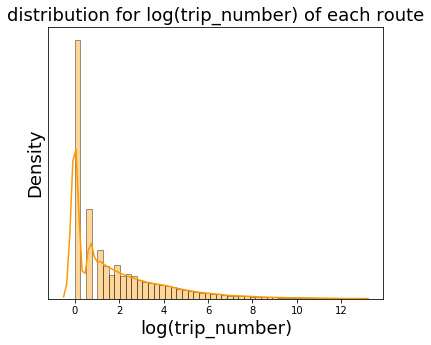

In [15]:
## Check image size distribution
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.distplot(np.log(taxi_yellow_gh6_trip_groupby_route.trip_number), bins=50, hist_kws={'edgecolor':'black'}, color='#ff9900')
ax.set_title('distribution for log(trip_number) of each route', fontsize=18)
ax.set_xlabel('log(trip_number)', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.set_yticks([])

In [16]:
taxi_yellow_gh6_trip_groupby_route.trip_number.quantile(np.arange(0,1,0.1))

0.0      1.0
0.1      1.0
0.2      1.0
0.3      1.0
0.4      2.0
0.5      3.0
0.6      5.0
0.7     10.0
0.8     27.0
0.9    117.0
Name: trip_number, dtype: float64

In [17]:
total_trip = taxi_yellow_gh6_trip_groupby_route.trip_number.sum()
print('Total number of trips for NYC yellow taxi: {}'.format(total_trip))
trip_365_df = taxi_yellow_gh6_trip_groupby_route[taxi_yellow_gh6_trip_groupby_route.trip_number >= 365*7]
print('Total number of routes with more than an average of 7 trips every day: {}'.format(trip_365_df.shape[0]))
trip_365 = trip_365_df.trip_number.sum()
print('Total number of trips for routes with more than an average of 7 trips every day: {}'.format(trip_365))

Total number of trips for NYC yellow taxi: 142740946
Total number of routes with more than an average of 7 trips every day: 6108
Total number of trips for routes with more than an average of 7 trips every day: 125367465


**The most popular 6108 routes out of 320727 (1.90%) total unique routes for NYC yellow taxi account for 125367465 out of 142740946 (87.83%) total trips in year 2015**

In [18]:
taxi_yellow_gh6_trip_groupby_route_top10 = taxi_yellow_gh6_trip_groupby_route.iloc[:10,:]
print('Total number of trips for top10 most popular routes: {}({:.2f}%)'.format(taxi_yellow_gh6_trip_groupby_route_top10.trip_number.sum(), taxi_yellow_gh6_trip_groupby_route_top10.trip_number.sum()/total_trip*100))

Total number of trips for top10 most popular routes: 2977667(2.09%)


In [19]:
taxi_yellow_gh6_trip_groupby_route_top10.head()

,pickup_gh6,dropoff_gh6,pickup_gh6_long,pickup_gh6_lat,dropoff_gh6_long,dropoff_gh6_lat,trip_number,rank
141343,dr5rud,dr5ru6,-73.976440,40.751038,-73.987427,40.751038,330942,1
143185,dr5rue,dr5ru6,-73.976440,40.756531,-73.987427,40.751038,320519,2
135844,dr5ru7,dr5rus,-73.987427,40.756531,-73.976440,40.762024,320290,3
156973,dr5rus,dr5ru6,-73.976440,40.762024,-73.987427,40.751038,316044,4
133763,dr5ru6,dr5rus,-73.987427,40.751038,-73.976440,40.762024,292349,5


In [20]:
taxi_yellow_gh6_trip_groupby_route_top20 = taxi_yellow_gh6_trip_groupby_route.iloc[:20,:]
print('Total number of trips for top20 most popular routes: {}({:.2f}%)'.format(taxi_yellow_gh6_trip_groupby_route_top20.trip_number.sum(), taxi_yellow_gh6_trip_groupby_route_top20.trip_number.sum()/total_trip*100))

Total number of trips for top20 most popular routes: 5395670(3.78%)


# 3. Visualize the top10 and top20 most popular routes

In order to compare the result from geohash with result obtained from the previous K-means clustering, the routes will be drawn on the previous clustering map.

In [21]:
LL = (-74.30, -73.70, 40.56, 40.90)

In [22]:
cl_yellow_df = pd.read_csv('cluster_kmeans/nyc_taxi_yellow_2015_combine_1000000_filter_kmeans15_joint.csv')
centroid_yellow = pd.read_csv('cluster_kmeans/nyc_taxi_yellow_2015_combine_1000000_filter_kmeans15_joint_centroid.csv')

In [26]:
def plot_cluster2(df, taxi, centroid, cluster_n, route_df, route_n, arrow_col,title):
    def get_cmap(n, name='tab20'):   ## name = 'hsv'
        return plt.cm.get_cmap(name, n)
    cl_to_label_dict = {i:'cluster'+str(i) for i in np.arange(cluster_n)}
    color_list = get_cmap(cluster_n, name = 'tab20')
    colors = {'green':'#59b300', 'yellow':'#ff9900'}
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
    for i in np.arange(cluster_n):
        ax.scatter(np.array(df[df.pick_cl == i].pickup_longitude), np.array(df[df.pick_cl == i].pickup_latitude), marker='.', alpha = 0.3, s = 0.3, color = color_list(i), label=cl_to_label_dict[i], zorder=0)
        ax.scatter(np.array(df[df.drop_cl == i].dropoff_longitude), np.array(df[df.drop_cl == i].dropoff_latitude), marker='.', alpha = 0.3, s = 0.3, color = color_list(i), zorder=0)
    
    leg = ax.legend(loc = 'upper left', edgecolor = colors[taxi])
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        lh._sizes = [60]
    
    ax.set_xlim((LL[0], LL[1]))
    ax.set_ylim(LL[2], LL[3])
    ax.set_title(title, fontsize=20)
    
    route_df = route_df.iloc[:route_n,:]
    ax.plot(route_df.pickup_gh6_long, route_df.pickup_gh6_lat, 'o', color = 'r')
    ax.plot(route_df.dropoff_gh6_long, route_df.dropoff_gh6_lat, '*', color = 'b')
    for i in np.arange(route_n): 
        dist_x = route_df.iloc[i,:].pickup_gh6_long - route_df.iloc[i,:].dropoff_gh6_long
        dist_y = route_df.iloc[i,:].pickup_gh6_lat - route_df.iloc[i,:].dropoff_gh6_lat
        pct = np.true_divide(route_df.iloc[i,:].trip_number,route_df.trip_number.sum())
        #arr = Arrow(centroid.centroid_pick_long[centroid.pick_cl == i].values, centroid.centroid_pick_lat[centroid.pick_cl == i].values, -dist_x, -dist_y, edgecolor='white', width = 30*pct)
        arr = Arrow(route_df.iloc[i,:].pickup_gh6_long, route_df.iloc[i,:].pickup_gh6_lat, -dist_x, -dist_y, width = 0.05*pct, zorder=1)
        ax.add_patch(arr)
        arr.set_facecolor(arrow_col)

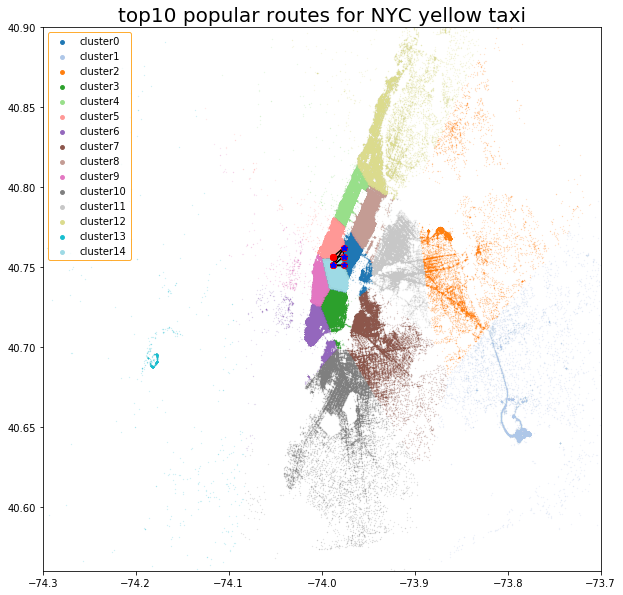

In [27]:
title = 'top10 popular routes for NYC yellow taxi'
plot_cluster2(df=cl_yellow_df, taxi='yellow', centroid=centroid_yellow, cluster_n=15, route_df = taxi_yellow_gh6_trip_groupby_route, route_n=10,arrow_col='black', title = title)

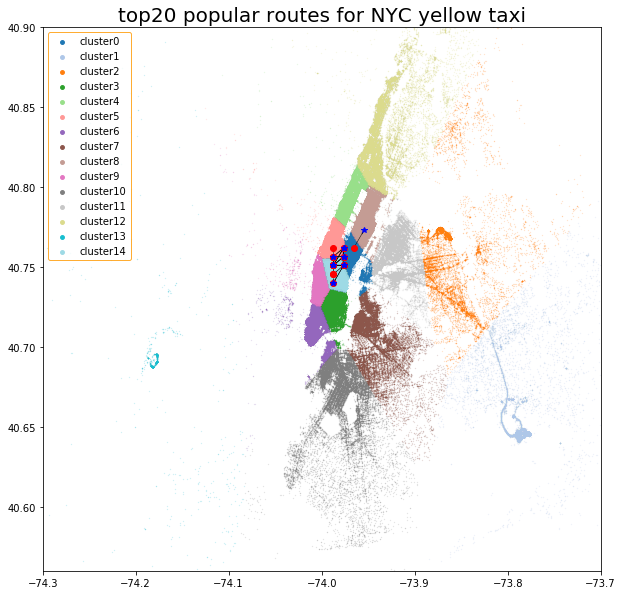

In [28]:
title = 'top20 popular routes for NYC yellow taxi'
plot_cluster2(df=cl_yellow_df, taxi='yellow', centroid=centroid_yellow, cluster_n=15, route_df = taxi_yellow_gh6_trip_groupby_route,route_n = 20, arrow_col='black', title = title)

In [27]:
import folium
def clusters_map(df, tile = 'OpenStreetMap', zoom = 12, radius = 30):
    map_1 = folium.Map(location=[40.767937, -73.982155], zoom_start=zoom,tiles='OpenStreetMap')
    for i in np.arange(df.shape[0]):
        rank = df.shape[0]-i
        route = df.iloc[i,]
        trip_number = route.trip_number
        pop = 'rank'+str(rank)+' & number of trips =' + str(trip_number)
        folium.CircleMarker(location=[route.pickup_gh6_lat, route.pickup_gh6_long], radius=radius, color='#F08080',fill_color='#F08080', popup=pop).add_to(map_1)
        folium.CircleMarker(location=[route.dropoff_gh6_lat, route.dropoff_gh6_long], radius=radius, color='#3186cc',fill_color='#3186cc', popup=pop).add_to(map_1)
        folium.Marker([route.pickup_gh6_lat, route.pickup_gh6_long], popup=pop).add_to(map_1)
    return map_1

In [28]:
df = taxi_yellow_gh6_trip_groupby_route_top10.sort_values(by = 'trip_number')
clusters_map(df, tile = 'OpenStreetMap', zoom = 12, radius = 10)

## Routes centered in midtown Manhattan
As we can see from the map plotted above, the top10 popular routes for NYC yellow taxi operate between transportation hubs or popular spots in Manhattan such as Port Authority, Penn Station and Grand Central. Here I combine these routes together to have a general analysis of the trip density patterns.

In [30]:
gh6_top10_pick_ghs = np.unique(taxi_yellow_gh6_trip_groupby_route_top10.pickup_gh6)
gh6_top10_drop_ghs = np.unique(taxi_yellow_gh6_trip_groupby_route_top10.dropoff_gh6)
print('pickup location geohash label: {}'.format(gh6_top10_pick_ghs))
print('dropoff locations geohash label: {}'.format(gh6_top10_drop_ghs))

pickup location geohash label: ['dr5ru6' 'dr5ru7' 'dr5rud' 'dr5rue' 'dr5rus']
dropoff locations geohash label: ['dr5ru6' 'dr5rud' 'dr5rue' 'dr5rus']


In [32]:
pick_array = np.array(taxi_yellow_gh6_trip_groupby_route_top10.pickup_gh6)
drop_array = np.array(taxi_yellow_gh6_trip_groupby_route_top10.dropoff_gh6)
print(pick_array)
print(drop_array)

['dr5rud' 'dr5rue' 'dr5ru7' 'dr5rus' 'dr5ru6' 'dr5ru6' 'dr5ru7' 'dr5ru6'
 'dr5ru7' 'dr5rue']
['dr5ru6' 'dr5ru6' 'dr5rus' 'dr5ru6' 'dr5rus' 'dr5rud' 'dr5ru6' 'dr5rue'
 'dr5rue' 'dr5rus']


In [34]:
#taxi_yellow_gh6_trip_top10 = taxi_yellow_gh6_trip[((taxi_yellow_gh6_trip.pickup_gh6==pick_array[0])&(taxi_yellow_gh6_trip.dropoff_gh6==drop_array[0]))]
mask_list = []
for i in np.arange(10):
    mask=(taxi_yellow_gh6_trip.pickup_gh6==pick_array[i])&(taxi_yellow_gh6_trip.dropoff_gh6==drop_array[i])
    mask_list.append(mask)
top10_mask = mask_list[0]|mask_list[1]|mask_list[2]|mask_list[3]|mask_list[4]|mask_list[5]|mask_list[6]|mask_list[7]|mask_list[8]|mask_list[9]

In [45]:
taxi_yellow_gh6_trip_top10 = taxi_yellow_gh6_trip[top10_mask]

In [46]:
taxi_yellow_gh6_trip_top10.shape

(86452, 11)

In [47]:
taxi_yellow_gh6_trip_top10.head()

,weekday,hour,month,day_of_year,pickup_gh6,pickup_gh6_lat,pickup_gh6_long,dropoff_gh6,dropoff_gh6_lat,dropoff_gh6_long,trip_number
19306481,3,7,9,253,dr5rue,40.756531,-73.97644,dr5rus,40.762024,-73.97644,228
19529227,3,8,7,190,dr5rue,40.756531,-73.97644,dr5rus,40.762024,-73.97644,197
7119325,1,8,2,55,dr5rue,40.756531,-73.97644,dr5rus,40.762024,-73.97644,196
1399725,0,8,4,110,dr5rue,40.756531,-73.97644,dr5rus,40.762024,-73.97644,193
13120989,2,8,2,35,dr5rue,40.756531,-73.97644,dr5rus,40.762024,-73.97644,191


Text(0.5, 1.0, 'Daily trip number in year 2015 for the top10 popular NYC yellow taxi routes')

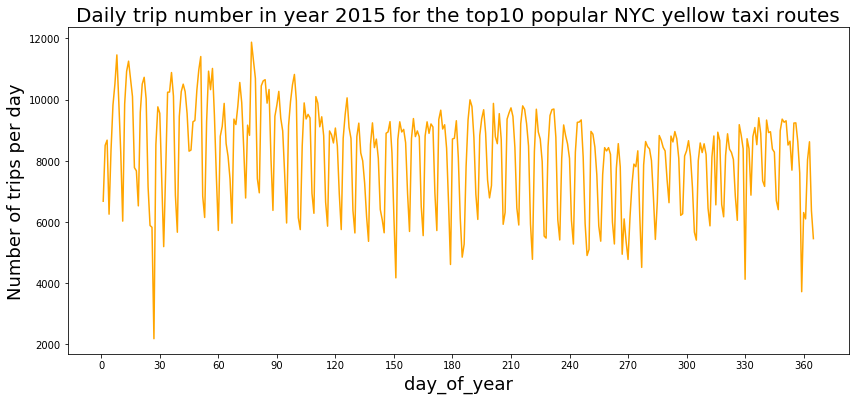

In [49]:
taxi_yellow_gh6_trip_top10_dayofyear = taxi_yellow_gh6_trip_top10.groupby(['day_of_year'], as_index = False).sum()[['day_of_year', 'trip_number']]
fig = plt.figure(figsize = (14,6))
plt.plot(taxi_yellow_gh6_trip_top10_dayofyear.day_of_year, taxi_yellow_gh6_trip_top10_dayofyear.trip_number, color = 'orange')
plt.xlabel('day_of_year', fontsize = 18)
plt.ylabel('Number of trips per day', fontsize = 18)
plt.xticks(np.arange(0,365, 30))
plt.title('Daily trip number in year 2015 for the top10 popular NYC yellow taxi routes', fontsize = 20)

Text(0.5, 1.0, 'Average Daily trip number in year 2015 for the top10 popular NYC yellow taxi routes \n(groupby day_of_week)')

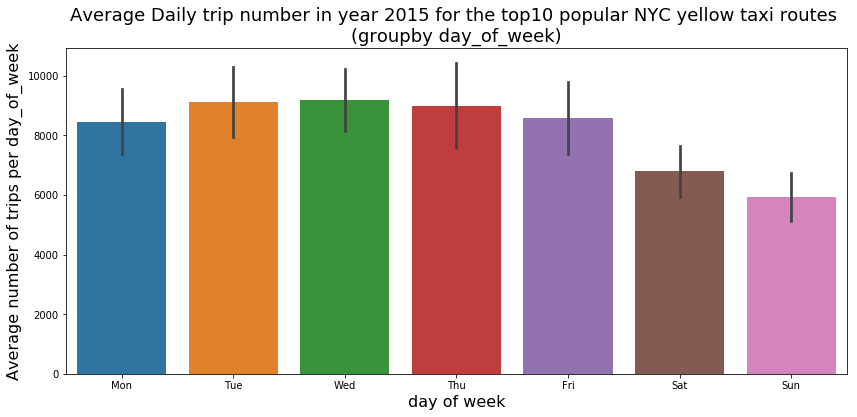

In [50]:
fig,ax = plt.subplots(figsize = (14,6))
taxi_yellow_gh6_trip_top10_dayofweek = taxi_yellow_gh6_trip_top10.groupby(['day_of_year','weekday'], as_index = False).sum()[['day_of_year','weekday','trip_number']]
sns.barplot(x = 'weekday', y = 'trip_number', data =taxi_yellow_gh6_trip_top10_dayofweek, ci='sd', ax = ax)
plt.xlabel('day of week', fontsize = 16)
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))
plt.ylabel('Average number of trips per day_of_week', fontsize = 16)
#plt.ylim(1000)
plt.title('Average Daily trip number in year 2015 for the top10 popular NYC yellow taxi routes \n(groupby day_of_week)', fontsize = 18)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Hourly trip number conditioned on day_of_week for NYC yellow taxi \nthe top10 popular routes')

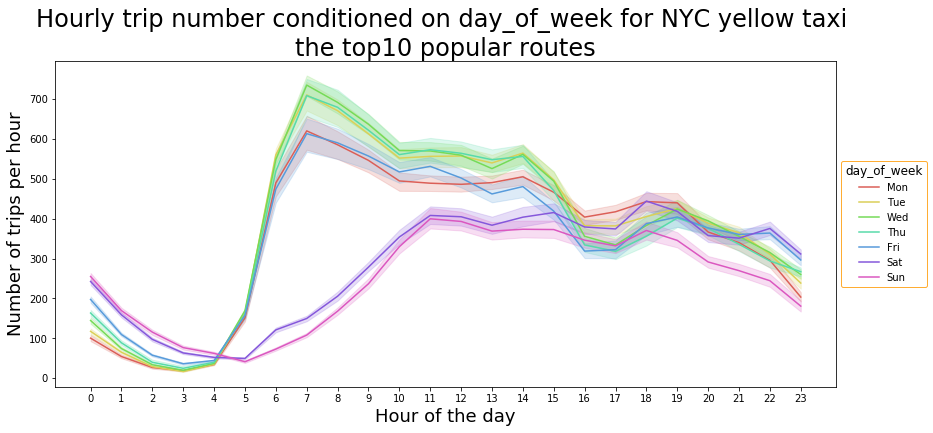

In [52]:
fig,ax = plt.subplots(figsize = (14,6))
palette = sns.color_palette("hls", 7)
taxi_yellow_gh6_trip_top10_day_hour = taxi_yellow_gh6_trip_top10.groupby(["day_of_year","hour", "weekday"], as_index = False).sum()[["weekday", "hour", "day_of_year", "trip_number"]]
sns.lineplot(x = 'hour', y = 'trip_number', hue = 'weekday',data = taxi_yellow_gh6_trip_top10_day_hour, ax = ax, palette = palette)
plt.legend(loc = 'center left', labels = ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'), title = 'day_of_week', title_fontsize = 12, edgecolor = '#ff9900', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hour of the day', fontsize = 18)
plt.xticks(np.arange(24))
plt.ylabel('Number of trips per hour', fontsize = 18)
plt.title('Hourly trip number conditioned on day_of_week for NYC yellow taxi \nthe top10 popular routes', fontsize = 24)

The popular NYC yellow taxi routes show different temporal traffic patterns between weekday and weekend. There is more traffic on weekday compared to weekend. On weekday, the taxi traffic peaks around 6-7 am in the morning, and slightly decreases but remains relatively constant until 3 pm. The taxi traffic on weekend slowly increases from 5 am until 11 am and remains constant until late night. These suggest that the majority of the trips on weekdays are work-related. Since the trips are all short ride, it would be very helpful if some public transportation methods such as shuttles could be organized in these areas that could significantly release the traffic pressure in eary morning on workday. 